In [ ]:
%cd /content/drive/MyDrive/segment-anything-2
!pip install -q -e .
!pip install datasets

/content/drive/MyDrive/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/1

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/advaith/')

Mounted at /content/drive


In [ ]:
def remove_regions_far_from_center(mask):
    # Ensure mask is binary, in case it's not
    _, mask_binary = cv2.threshold(mask.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_contour = None

    # Find the contour with the largest area
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        if contour_area > largest_area:
            largest_area = contour_area
            largest_contour = contour

    # Initialize an empty mask
    cleaned_mask = np.zeros_like(mask)

    # If a largest contour is found, fill it in on the cleaned mask
    if largest_contour is not None:
        largest_contour = largest_contour.reshape(-1, 1, 2)
        cv2.drawContours(cleaned_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    cleaned_mask = (cleaned_mask / 255).astype(np.uint8)

    return cleaned_mask

In [ ]:
def generate_object_mask_pairs(img_paths, mask_paths):
    all_images = []
    all_masks = []

    for mask_file in zip(os.listdir(mask_paths)):
        mask_file = mask_file[0]
        img_file = mask_file.replace('MasksSAM', '')
        img_path = os.path.join(img_paths, img_file)
        mask_path = os.path.join(mask_paths, mask_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_height, orig_width = img.shape[:2]

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask_binary = mask_binary // 255  # Convert to 0s and 1s

        # Get contours of the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Process each contour as an individual object
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Add padding to bounding box
            x_start = max(0, x - 10)
            y_start = max(0, y - 10)
            x_end = min(orig_width, x + w + 10)
            y_end = min(orig_height, y + h + 10)

            # Crop the image and mask based on the bounding box
            cropped_img = img[y_start:y_end, x_start:x_end]
            cropped_mask = mask[y_start:y_end, x_start:x_end]

            cropped_mask = remove_regions_far_from_center(cropped_mask)

            # Resize to uniform size
            cropped_img = cv2.resize(cropped_img, (256, 256))
            cropped_mask = cv2.resize(cropped_mask, (256, 256))

            cropped_img = (cropped_img / 255)[:, :, 0]

            # Append the cropped images and masks as individual entries
            all_images.append(cropped_img)
            all_masks.append(cropped_mask)


    return np.array(all_images), np.array(all_masks)

In [ ]:
from datasets import Dataset
from PIL import Image
import os
import cv2
import numpy as np

img_paths = '/content/drive/MyDrive/advaith/data/AV39-512/'
mask_paths = '/content/drive/MyDrive/advaith/data/AV39MasksSAM-512/'

all_images, all_masks = generate_object_mask_pairs(img_paths, mask_paths)

print("Image shape:", all_images.shape)
print("Mask shape:", all_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in all_images],
    "label": [Image.fromarray(mask) for mask in all_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

Image shape: (150, 256, 256)
Mask shape: (150, 256, 256)


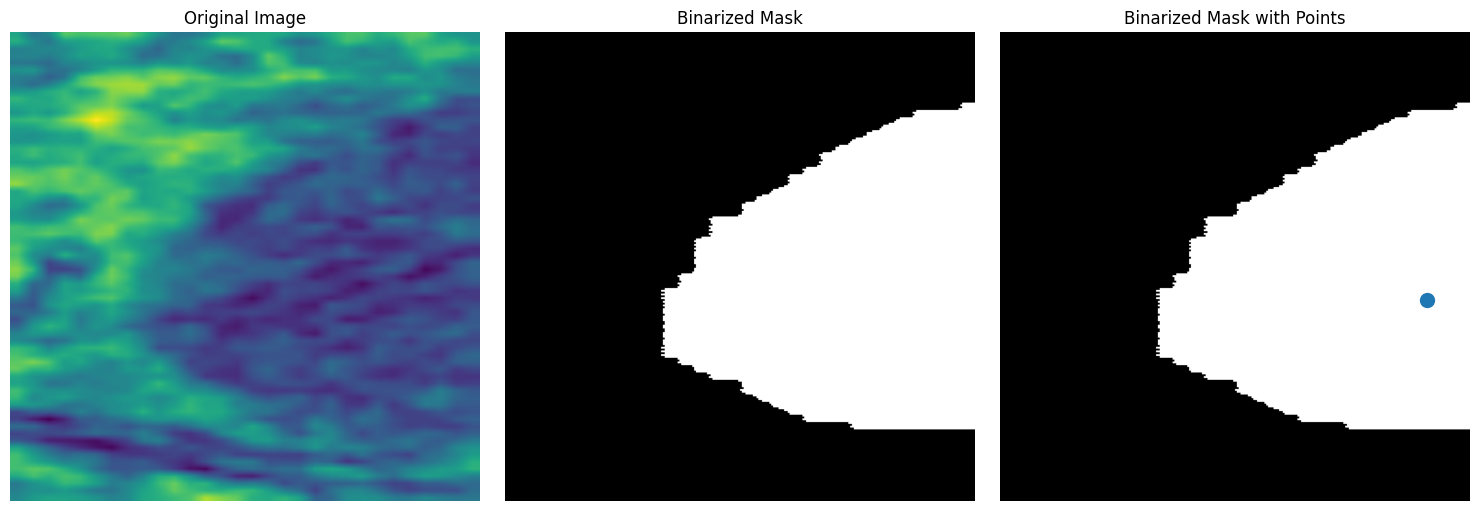

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def read_batch(data, visualize_data=False):
   # Select a random entry
   ent = data[np.random.randint(len(data))]

   Img = np.array(ent["image"])  # Convert BGR to RGB using NumPy
   ann_map = np.array(ent["label"])

   # Resize image and mask
   r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
   img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
   ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

   # Initialize a single binary mask
   binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
   points = []

   # Get binary masks and combine them into a single mask
   inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
   for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
       binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

   # Erode the combined binary mask to avoid boundary points
   eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

   # Get all coordinates inside the eroded mask and choose a random point
   coords = np.argwhere(eroded_mask > 0)
   if len(coords) > 0:
       for _ in inds:  # Select as many points as there are unique labels
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])

   points = np.array(points)
       ### Continuation of read_batch() ###

   if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

   binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
   binary_mask = binary_mask.transpose((2, 0, 1))
   points = np.expand_dims(points, axis=1)

   # Return the image, binarized mask, points, and number of masks
   return img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(dataset, visualize_data=True)


In [ ]:
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"

--2025-01-16 23:43:01--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.84, 13.35.238.103, 13.35.238.71, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_small.pt’

sam2_hiera_small.pt 100%[===================>] 175.77M   271MB/s    in 0.6s    

2025-01-16 23:43:02 (271 MB/s) - ‘sam2_hiera_small.pt’ saved [184309650/184309650]



In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
sam2_checkpoint = "sam2_hiera_small.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
import torch
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

<ipython-input-60-1973a65bc8c3>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(dataset, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       if image.ndim == 2:  # Check if the image is grayscale
          image = np.stack([image] * 3, axis=-1)

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

<ipython-input-72-ee40113c4237>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Step 100:	 Accuracy (IoU) =  0.513157267231064
Step 200:	 Accuracy (IoU) =  0.6971733754021237
Step 300:	 Accuracy (IoU) =  0.7936584361439071
Step 400:	 Accuracy (IoU) =  0.8254117425519016
Step 500:	 Accuracy (IoU) =  0.8452625639845117
Step 600:	 Accuracy (IoU) =  0.8581143352172792
Step 700:	 Accuracy (IoU) =  0.8591873823817087
Step 800:	 Accuracy (IoU) =  0.855523359477875
Step 900:	 Accuracy (IoU) =  0.8610109315020661
Step 1000:	 Accuracy (IoU) =  0.862064871899673
Step 1100:	 Accuracy (IoU) =  0.8698043771728206
Step 1200:	 Accuracy (IoU) =  0.8733651614233292
Step 1300:	 Accuracy (IoU) =  0.8747081713500492
Step 1400:	 Accuracy (IoU) =  0.8760254174830724
Step 1500:	 Accuracy (IoU) =  0.8710252012261799
Step 1600:	 Accuracy (IoU) =  0.8713269531651074
Step 1700:	 Accuracy (IoU) =  0.8717193877537257
Step 1800:	 Accuracy (IoU) =  0.8696989250854593
Step 1900:	 Accuracy (IoU) =  0.8718953497488967
Step 2000:	 Accuracy (IoU) =  0.8688801358279693


KeyboardInterrupt: 

In [ ]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

sam2_hiera_s.yaml
sam2_hiera_small.pt


<ipython-input-10-25fba570a632>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS, map_location=torch.dev

(256, 256, 3)


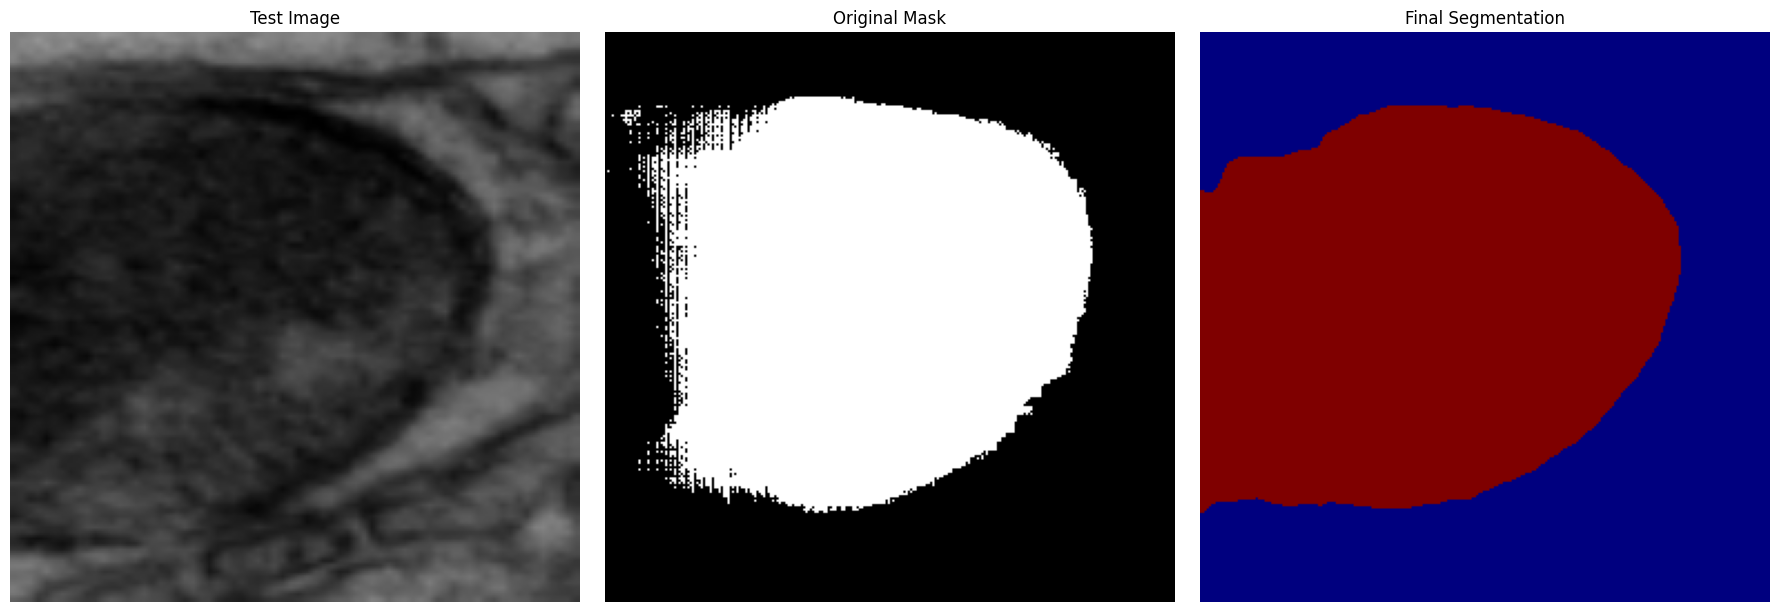

In [ ]:
import random
from scipy.ndimage import gaussian_filter
import torch

# Randomly select a test image from the test_data
selected_entry = random.choice(dataset)
image_path = selected_entry['image']
mask_path = selected_entry['label']

# Load the selected image and mask
image, mask = np.array(image_path), np.array(mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

print(model_cfg)
print(sam2_checkpoint)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "/content/drive/MyDrive/segment-anything-2/fine_tuned_sam2_2000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS, map_location=torch.device('cpu')))

if image.ndim == 2:  # Check if the image is grayscale
    image = np.stack([image] * 3, axis=-1)

print(image.shape)

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

seg_mask = gaussian_filter(seg_map.astype(float), sigma=2)
smoothed_mask = (seg_mask > 0.5).astype(np.uint8)

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(smoothed_mask, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()